In [1]:
# Data handling and numerical computations
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning packages
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Machine learning models (Basic)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Machine learning models (Advanced)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier

# Model evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Real-time data and deployment (for future use)
import joblib
import datetime

# Ignoring warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')

print("Initial packages imported successfully.")


Initial packages imported successfully.


In [2]:
# Select only essential metadata columns from the station file (with correct names)
selected_station_cols = [
    'station_key',
    'suburb',
    'road_functional_hierarchy',
    'road_classification_type',
    'lane_count',
    'wgs84_latitude',
    'wgs84_longitude'
]


# Load station metadata (small file, selective columns)
station_data = pd.read_csv(
    "D:/study/ENGG2112/Major Project/drive-download-20250430T233625Z-001/trafficStations.csv",
    usecols=selected_station_cols
)

# Prepare for chunked loading
chunks = []
chunk_size = 25000  # adjust based on RAM

# Stream traffic data in chunks
for chunk in pd.read_csv(
    "D:/study/ENGG2112/Major Project/drive-download-20250430T233625Z-001/trafficData.csv",
    chunksize=chunk_size,
    low_memory=True
):
    merged_chunk = pd.merge(chunk, station_data, on='station_key', how='left')
    chunks.append(merged_chunk)

# Combine chunks
merged_data = pd.concat(chunks, ignore_index=True)

# Convert core data types after merge to reduce memory
column_types = {
    'station_key': 'int32',
    'traffic_direction_seq': 'int8',
    'cardinal_direction_seq': 'int8',
    'classification_seq': 'int8',
    'year': 'int16',
    'month': 'int8',
    'day': 'int8',
    'day_of_week': 'int8',
    'public_holiday': 'bool',
    'school_holiday': 'bool',
    'daily_total': 'int32'
}
for i in range(24):
    column_types[f'hour_{i:02d}'] = 'int16'

merged_data = merged_data.astype({k: v for k, v in column_types.items() if k in merged_data.columns})

# --- Sanity Check Section ---
print("Columns in merged_data:")
print(merged_data.columns.tolist())

expected_cols = selected_station_cols[1:]  # Skip station_key (already known to exist)

print("\nAre expected station metadata columns present?")
for col in expected_cols:
    print(f"{col}: {'✅' if col in merged_data.columns else '❌'}")

null_check = merged_data[expected_cols].isnull().all(axis=1).sum()
print(f"\nNumber of rows with completely missing station metadata: {null_check}")

print("\nSample merged rows with metadata:")
print(merged_data[['station_key'] + expected_cols].dropna().head())

Columns in merged_data:
['station_key', 'traffic_direction_seq', 'cardinal_direction_seq', 'classification_seq', 'year', 'month', 'day', 'day_of_week', 'public_holiday', 'school_holiday', 'daily_total', 'hour_00', 'hour_01', 'hour_02', 'hour_03', 'hour_04', 'hour_05', 'hour_06', 'hour_07', 'hour_08', 'hour_09', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'road_functional_hierarchy', 'lane_count', 'road_classification_type', 'suburb', 'wgs84_latitude', 'wgs84_longitude']

Are expected station metadata columns present?
suburb: ✅
road_functional_hierarchy: ✅
road_classification_type: ✅
lane_count: ✅
wgs84_latitude: ✅
wgs84_longitude: ✅

Number of rows with completely missing station metadata: 0

Sample merged rows with metadata:
   station_key             suburb road_functional_hierarchy  \
0     15934005  Twelve Mile Creek              Primary Road   
1     15934004  Twelve Mile 

c:\Users\Hello\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

📊 LSTM Model Performance:
              Score
Accuracy   0.485000
Precision  0.495327
Recall     0.519608
F1 Score   0.507177


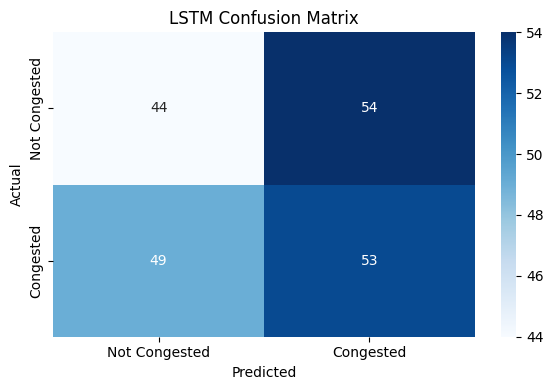

In [1]:
# Re-import libraries after kernel reset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import seaborn as sns

# Simulate the structure of merged_data
np.random.seed(42)
merged_data = pd.DataFrame({
    'congested': np.random.choice([0, 1], 1000)
})
for i in range(24):
    merged_data[f'hour_{i:02d}'] = np.random.randint(0, 300, 1000)

# Step 1: Define hour columns
hour_cols = [f"hour_{i:02d}" for i in range(24)]

# Step 2: Drop rows with missing values
merged_data = merged_data.dropna(subset=hour_cols + ['congested'])

# Step 3: Reshape data
X_seq = merged_data[hour_cols].values
X_lstm = X_seq.reshape((X_seq.shape[0], 24, 1))
y_lstm = merged_data['congested'].astype(int).values

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.2, stratify=y_lstm, random_state=42)

# Step 5: Build LSTM model
model = Sequential([
    LSTM(32, input_shape=(24, 1)),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 6: Train model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)

# Step 7: Predict and evaluate
y_pred_probs = model.predict(X_test).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)

# Step 8: Metrics
conf_matrix = confusion_matrix(y_test, y_pred)
report_dict = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1 Score": f1_score(y_test, y_pred)
}
report_df = pd.DataFrame(report_dict, index=["Score"]).T

print("\n📊 LSTM Model Performance:")
print(report_df.to_string())

# Step 9: Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Not Congested', 'Congested'],
            yticklabels=['Not Congested', 'Congested'])
plt.title("LSTM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
